In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [ ]:
candidate_name = "varun_ravichander"
base_dir = f"/content/ds_{candidate_name}"

In [ ]:
csv_dir = f"{base_dir}/csv_files"
output_dir = f"{base_dir}/outputs"
data_dir = f"{base_dir}/data"

In [7]:
os.makedirs(csv_dir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)
os.makedirs(data_dir, exist_ok=True)


In [8]:
trader_path = f"{csv_dir}/historical_data.csv"
sentiment_path = f"{csv_dir}/fear_greed_index.csv"

In [9]:
trader_df = pd.read_csv(trader_path)
sentiment_df = pd.read_csv(sentiment_path)

In [10]:
print("=== Trader Data ===")
print(trader_df.shape)
print(trader_df.columns.tolist())
print(trader_df.head(2))

=== Trader Data ===
(211224, 16)
['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp']
                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   

   Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   

   Closed PnL                                   Transaction Hash     Order ID  \
0         0.0  0xec09451986a1874e3a980418412fcd0201f500c95bac...  52017706630   
1         0.0  0xec09451986a1874e3a980418412fcd0201f500c95bac...  52017706630   

   Crossed       Fee      Trade ID     Timestamp  
0     True  

In [11]:
print("\n=== Sentiment Data ===")
print(sentiment_df.shape)
print(sentiment_df.columns.tolist())
print(sentiment_df.head(2))


=== Sentiment Data ===
(2644, 4)
['timestamp', 'value', 'classification', 'date']
    timestamp  value classification        date
0  1517463000     30           Fear  2018-02-01
1  1517549400     15   Extreme Fear  2018-02-02


In [12]:
trader_df = trader_df.rename(columns={
    'Account': 'account',
    'Coin': 'symbol',
    'Execution Price': 'price',
    'Size Tokens': 'size_tokens',
    'Size USD': 'size_usd',
    'Side': 'side',
    'Closed PnL': 'closed_pnl',
    'Timestamp IST': 'timestamp_ist',
    'Timestamp': 'timestamp'
})

# Extract Date
if 'timestamp_ist' in trader_df.columns:
    trader_df['date'] = pd.to_datetime(trader_df['timestamp_ist'], format='%d-%m-%Y %H:%M', errors='coerce').dt.date
else:
    trader_df['date'] = pd.to_datetime(trader_df['timestamp'], errors='coerce').dt.date

sentiment_df['date'] = pd.to_datetime(sentiment_df['date'], errors='coerce').dt.date

print("\nDate ranges:")
print("Trader:", trader_df['date'].min(), "->", trader_df['date'].max())
print("Sentiment:", sentiment_df['date'].min(), "->", sentiment_df['date'].max())



Date ranges:
Trader: 2023-05-01 -> 2025-05-01
Sentiment: 2018-02-01 -> 2025-05-02


In [13]:
if 'leverage' not in trader_df.columns:
    print("⚠️ Leverage not found — adding placeholder (NaN)")
    trader_df['leverage'] = np.nan

# Compute Profit Percentage
trader_df['pnl_pct'] = trader_df.apply(
    lambda row: (row['closed_pnl'] / row['size_usd'] * 100)
    if pd.notnull(row['size_usd']) and row['size_usd'] != 0
    else np.nan,
    axis=1
)


⚠️ Leverage not found — adding placeholder (NaN)


In [14]:
merged_df = pd.merge(
    trader_df,
    sentiment_df[['date', 'value', 'classification']],
    on='date',
    how='left'
)

print(f"\nMerged rows: {len(merged_df)}")
print("Mapped sentiment fraction:", round(merged_df['classification'].notnull().mean(), 4))


Merged rows: 211224
Mapped sentiment fraction: 1.0


In [15]:
print("\n=== Summary Statistics by Market Sentiment ===")
summary_stats = merged_df.groupby('classification').agg({
    'closed_pnl': ['mean', 'median', 'count', 'std'],
    'size_usd': ['mean', 'median', 'count', 'std'],
    'leverage': ['mean', 'median', 'count'],
    'pnl_pct': ['mean', 'median', 'std']
})
print(summary_stats)


=== Summary Statistics by Market Sentiment ===
               closed_pnl                                size_usd           \
                     mean median  count          std         mean   median   
classification                                                               
Extreme Fear    34.537862    0.0  21400  1136.056091  5349.731843  766.150   
Extreme Greed   67.892861    0.0  39992   766.828294  3112.251565  500.050   
Fear            54.290400    0.0  61837   935.355438  7816.109931  735.960   
Greed           42.743559    0.0  50303  1116.028390  5736.884375  555.000   
Neutral         34.307718    0.0  37686   517.122220  4782.732661  547.655   

                                    leverage                pnl_pct         \
                count           std     mean median count      mean median   
classification                                                               
Extreme Fear    21400  22306.826180      NaN    NaN     0  0.432142    0.0   
Extreme Greed  

In [16]:
# Correlation Matrix
corr_matrix = merged_df[['closed_pnl', 'size_usd', 'leverage', 'value', 'pnl_pct']].corr()
print("\n=== Correlation Matrix ===")
print(corr_matrix)

corr_matrix.to_csv(f"{data_dir}/correlation_matrix.csv")


=== Correlation Matrix ===
            closed_pnl  size_usd  leverage     value   pnl_pct
closed_pnl    1.000000  0.123589       NaN  0.008121  0.039508
size_usd      0.123589  1.000000       NaN -0.029843 -0.001887
leverage           NaN       NaN       NaN       NaN       NaN
value         0.008121 -0.029843       NaN  1.000000  0.012879
pnl_pct       0.039508 -0.001887       NaN  0.012879  1.000000


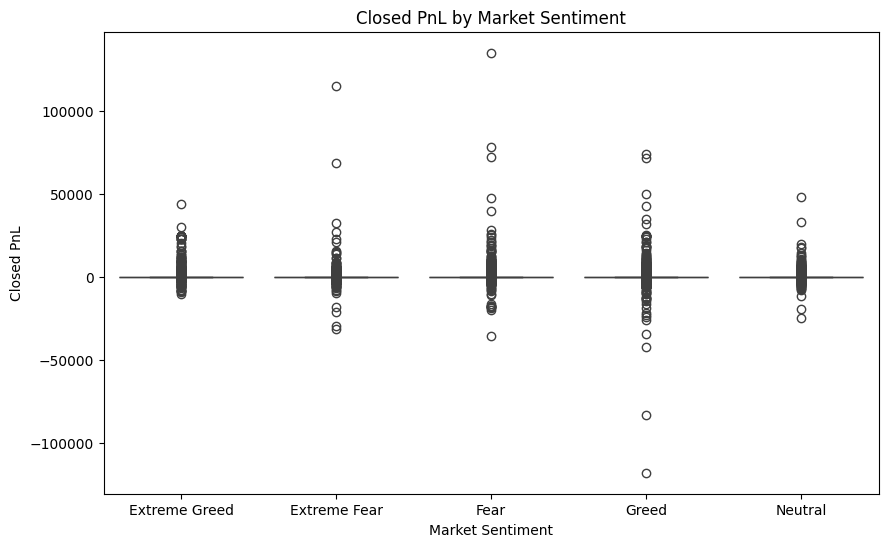

In [17]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='classification', y='closed_pnl', data=merged_df)
plt.title('Closed PnL by Market Sentiment')
plt.xlabel('Market Sentiment')
plt.ylabel('Closed PnL')
plt.savefig(f"{output_dir}/box_closedpnl_sentiment.png")
plt.show()

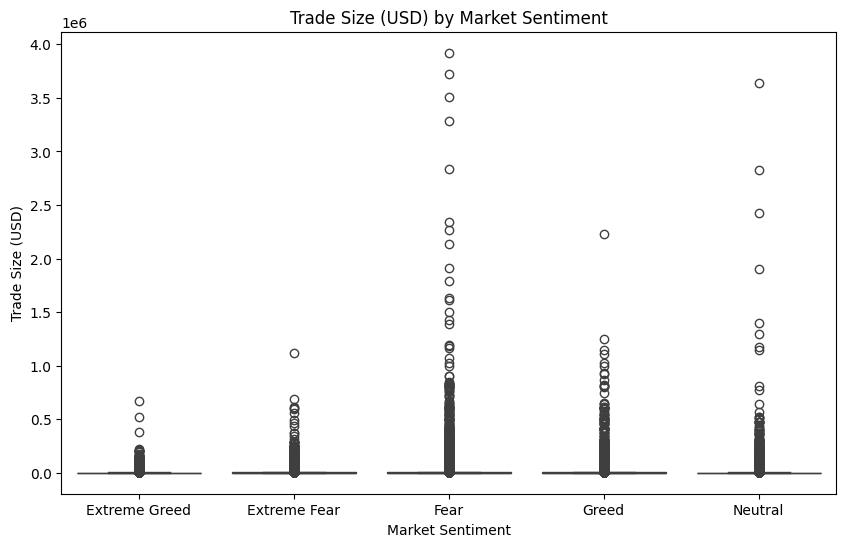

In [18]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='classification', y='size_usd', data=merged_df)
plt.title('Trade Size (USD) by Market Sentiment')
plt.xlabel('Market Sentiment')
plt.ylabel('Trade Size (USD)')
plt.savefig(f"{output_dir}/box_sizeusd_sentiment.png")
plt.show()

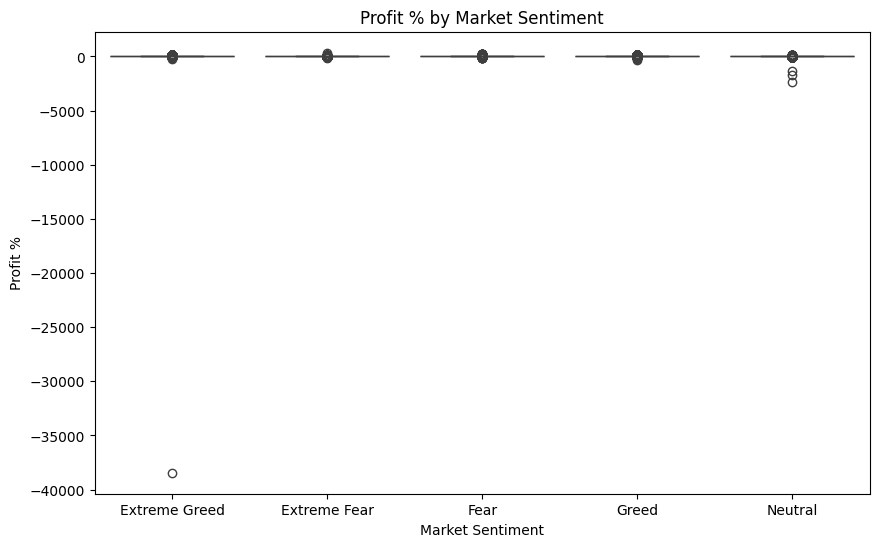

In [19]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='classification', y='pnl_pct', data=merged_df)
plt.title('Profit % by Market Sentiment')
plt.xlabel('Market Sentiment')
plt.ylabel('Profit %')
plt.savefig(f"{output_dir}/box_pnlpct_sentiment.png")
plt.show()

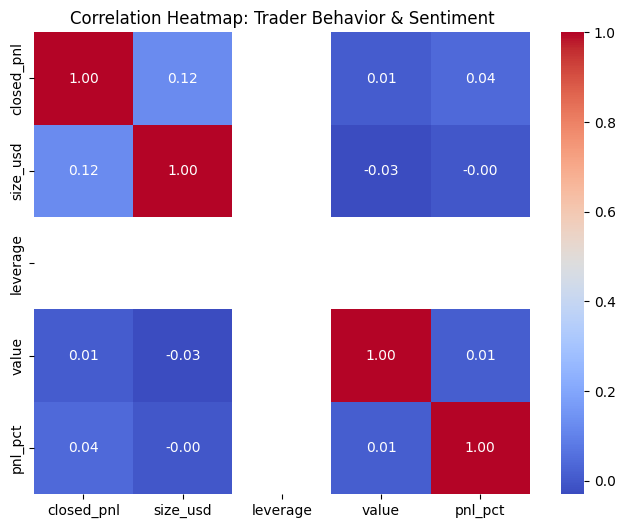

In [20]:
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap: Trader Behavior & Sentiment')
plt.savefig(f"{output_dir}/correlation_heatmap.png")
plt.show()

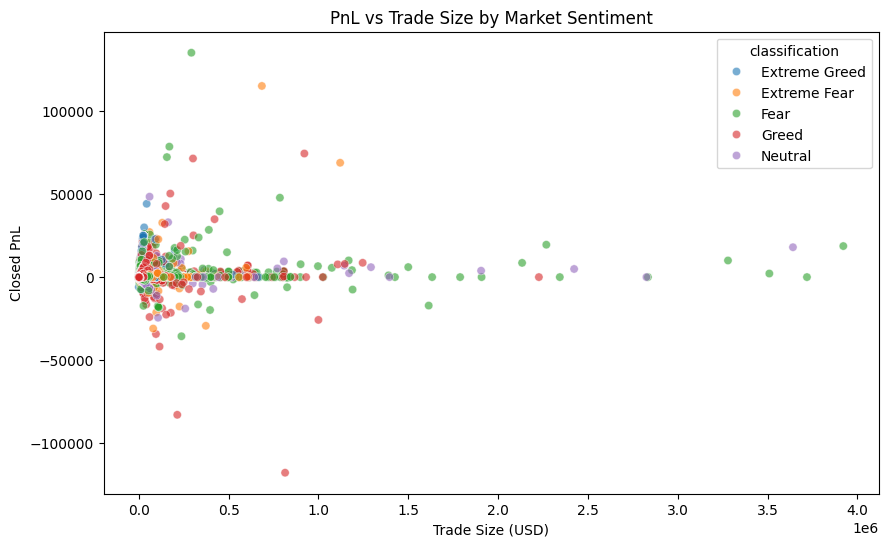

In [22]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='size_usd', y='closed_pnl', hue='classification', data=merged_df, alpha=0.6)
plt.title('PnL vs Trade Size by Market Sentiment')
plt.xlabel('Trade Size (USD)')
plt.ylabel('Closed PnL')
plt.savefig(f"{output_dir}/scatter_pnl_vs_size.png")
plt.show()

In [23]:
agg_funcs = {
    'closed_pnl': ['mean', 'sum', 'std'],
    'size_usd': ['mean', 'sum'],
    'pnl_pct': ['mean'],
    'leverage': ['mean']
}
daily = merged_df.groupby('date').agg(agg_funcs)
daily.columns = ["_".join(col).strip() for col in daily.columns.values]
daily.reset_index(inplace=True)

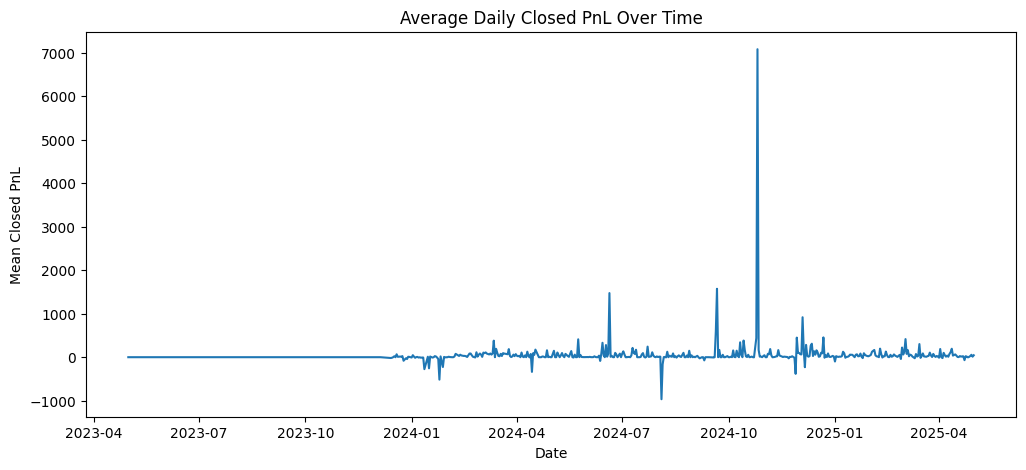

In [24]:
plt.figure(figsize=(12, 5))
plt.plot(daily['date'], daily['closed_pnl_mean'])
plt.title('Average Daily Closed PnL Over Time')
plt.xlabel('Date')
plt.ylabel('Mean Closed PnL')
plt.savefig(f"{output_dir}/daily_pnl_trend.png")
plt.show()

In [25]:
merged_df.to_csv(f"{data_dir}/merged_trader_sentiment_final.csv", index=False)
summary_stats.to_csv(f"{data_dir}/summary_by_sentiment.csv")

print(f"\n✅ All processed files, visuals, and summaries saved successfully inside:")
print(f"📁 {base_dir}")


✅ All processed files, visuals, and summaries saved successfully inside:
📁 /content/ds_varun_ravichander
